In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('input/train.csv', index_col='id')
test = pd.read_csv('input/test.csv', index_col='id')
sub = pd.read_csv('input/sample_submission.csv')
print(train.shape, test.shape)

(4752, 59) (11520, 40)


In [4]:
# https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

In [65]:
# 기상청 데이터만 추출
X_train = train.loc[:,'X00':'X39']

# standardization을 위해 평균과 표준편차 구하기
MEAN = X_train.mean()
STD = X_train.std()

# 표준편차가 0일 경우 대비하여 1e-07 추가 
X_train = (X_train - MEAN) / (STD + 1e-07)


# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in range(df.shape[0] - interval):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target


y_columns = ['Y15', 'Y16']
# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
sequence = np.empty((0, 12, 40))
target = np.empty((0,))

for column in y_columns :
    
    concat = pd.concat([X_train, train[column]], axis=1)

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval=12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))
    

In [73]:
sequence.shape

(8616, 12, 40)

In [71]:
target.shape

(8616,)

In [85]:
sequence[0].shape

(12, 40)

In [89]:
dataset = []
for i, seq in enumerate(sequence):
    dataset.append((seq, target[i]))

In [90]:
dataset[0]

(array([[-2.23637748e+00,  5.32433203e-02, -2.88997496e-01,
         -9.11345214e-01, -2.86741663e-01,  2.84562007e-01,
          1.74781832e-01, -2.16075236e+00,  3.15215682e-01,
          3.96434785e-01, -3.02830441e-01, -1.01240985e+00,
          6.36957490e-01, -9.11630274e-01,  0.00000000e+00,
         -7.49051966e-01,  0.00000000e+00, -9.11857682e-01,
         -9.32848171e-01,  0.00000000e+00,  8.94215730e-01,
         -2.79076247e-01,  2.15815603e-01,  2.77680775e-01,
          1.05323566e-01, -1.04402392e+00, -7.01012642e-01,
          3.32245521e-01, -2.31445447e+00,  2.32454335e-01,
          1.59918664e-01, -2.10977914e+00, -1.76662329e+00,
          2.97980549e-01, -1.01588128e+00,  4.82016708e-01,
         -2.74946285e-01,  5.77719506e-01,  2.40702722e-01,
         -2.34575896e-01],
        [-2.32134700e+00,  8.30059668e-02,  1.77482158e-01,
          4.77319922e-01, -2.86741663e-01,  2.84562007e-01,
          1.74781832e-01, -2.18359793e+00,  3.43622216e-01,
          4.2

In [48]:
    
    
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
X_train['dummy'] = 0

# train set에서 도출된 평균과 표준편차로 standardization 실시 
test = (test - MEAN) / (STD + 1e-07)

# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
test['dummy'] = 0

# train과 test 기간을 합쳐서 120분 간격으로 학습데이터 재구축
X_test, _ = convert_to_timeseries(pd.concat([X_train, test], axis=0), interval=12)

# test set 기간인 후반부 80일에 맞게 자르기 
X_test = X_test[-11520:, :, :]

# 만들어 두었던 dummy feature 제거
X_train = X_train.drop('dummy', axis=1)
test = test.drop('dummy', axis=1)

In [63]:
sequence.shape

(8616, 12, 40)

In [64]:
test.shape

(11520, 40)

In [11]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [59]:
tt[1].shape

(12924,)

In [60]:
tt[0].shape

(12924, 12, 40)

In [46]:
sequence[0].shape, target

((12, 40), array([ 8. ,  8. ,  8. , ..., 20. , 20. , 19.5]))

In [12]:
sequence1 = torch.Tensor(sequence)
target1 = torch.Tensor(target)

In [91]:
import random
import numpy as np
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

In [92]:
dataset

array([[  0,   5,   5],
       [ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [ ]:
# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

# seq_length = 4
# x, y = sliding_windows(training_data, seq_length)

# train_size = int(len(y) * 0.67)
# test_size = len(y) - train_size

# dataX = torch.Tensor(np.array(x))
# dataY = torch.Tensor(np.array(y))

# trainX = torch.Tensor(np.array(x[0:train_size]))
# trainY = torch.Tensor(np.array(y[0:train_size]))

# testX = torch.Tensor(np.array(x[train_size:len(x)]))
# testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [25]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                        num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [26]:
sequence.shape

(8616, 12, 40)

In [27]:
sequence.shape[-2:]

(12, 40)

In [40]:
target1.shape

torch.Size([8616])

In [43]:
num_epochs = 5
learning_rate = 0.01

input_size = sequence.shape[-2:]
hidden_size = 128
num_layers = 1

num_classes = 1



lstm = LSTM(input_dim=12, hidden_dim=128, batch_size=40)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)



# Train the model
for epoch in range(num_epochs):
    outputs = lstm(sequence1)
    optimizer.zero_grad()
    print(outputs.shape)
    print(outputs)
    # obtain the loss function
    loss = criterion(outputs, target1)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([40])
tensor([0.1062, 0.1092, 0.1020, 0.1041, 0.0992, 0.1045, 0.1079, 0.0997, 0.0963,
        0.1018, 0.1036, 0.1014, 0.1011, 0.1033, 0.1031, 0.0996, 0.1066, 0.0969,
        0.0968, 0.1010, 0.1032, 0.1059, 0.1085, 0.1032, 0.1024, 0.0975, 0.1076,
        0.0973, 0.1046, 0.1015, 0.1036, 0.0976, 0.0994, 0.1026, 0.1098, 0.1049,
        0.1063, 0.0969, 0.1003, 0.1010], grad_fn=<ViewBackward>)


RuntimeError: The size of tensor a (40) must match the size of tensor b (8616) at non-singleton dimension 0

In [ ]:
a

In [20]:
train['Y18'].isna().sum()

4320

In [21]:
test.shape

(11520, 40)

In [28]:
(11520 + 4320) * 0.8

12672.0

In [24]:
vv = (test['X00'] + test['X07'] + test['X28'] + test['X31'] + test['X32'])/5
vv

id
4752     19.94
4753     19.92
4754     19.90
4755     19.72
4756     19.68
         ...  
16267    25.54
16268    25.84
16269    25.70
16270    25.68
16271    25.66
Length: 11520, dtype: float64

In [25]:
sub.loc[:, 'Y18'] = vv.values

In [26]:
sub.to_csv('test-sb.csv', index=False)

In [ ]:
A지역: X00 / B지역: X07 / C지역: X28 / D지역: X31 / E지역: X32

In [13]:
(test['X00']+test['X07']+test['X28'] + test['X31'] + test['X32'])/5

id
4752     19.94
4753     19.92
4754     19.90
4755     19.72
4756     19.68
         ...  
16267    25.54
16268    25.84
16269    25.70
16270    25.68
16271    25.66
Length: 11520, dtype: float64

In [14]:
test['X07']

id
4752     21.1
4753     21.2
4754     21.2
4755     21.1
4756     20.9
         ... 
16267    26.3
16268    26.3
16269    26.2
16270    26.1
16271    26.0
Name: X07, Length: 11520, dtype: float64

In [8]:
test.loc[4320:, ['X07', 'Y18']]

/Users/unerue/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,X07,Y18
id,,
4752,21.1,NaN
4753,21.2,NaN
4754,21.2,NaN
4755,21.1,NaN
4756,20.9,NaN
...,...,...
16267,26.3,NaN
16268,26.3,NaN
16269,26.2,NaN


In [279]:
train.loc[4320:, ['X07', 'Y18']]

,X07,Y18
id,,
4320,20.8,20.5
4321,20.6,20.5
4322,20.5,20.5
4323,20.5,20.5
4324,20.5,20.5
...,...,...
4747,21.7,21.5
4748,21.6,21.5
4749,21.4,21.5


In [398]:
train.loc[:4320, 'Y18'] = train.loc[:4320, 'X07']

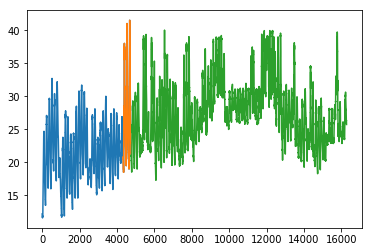

In [399]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(sharey=True)
ax.plot(train['Y18'])
ax.plot(train.loc[4320:, 'Y18'])
ax.plot(range(4752, 16272), test_preds)
plt.show()

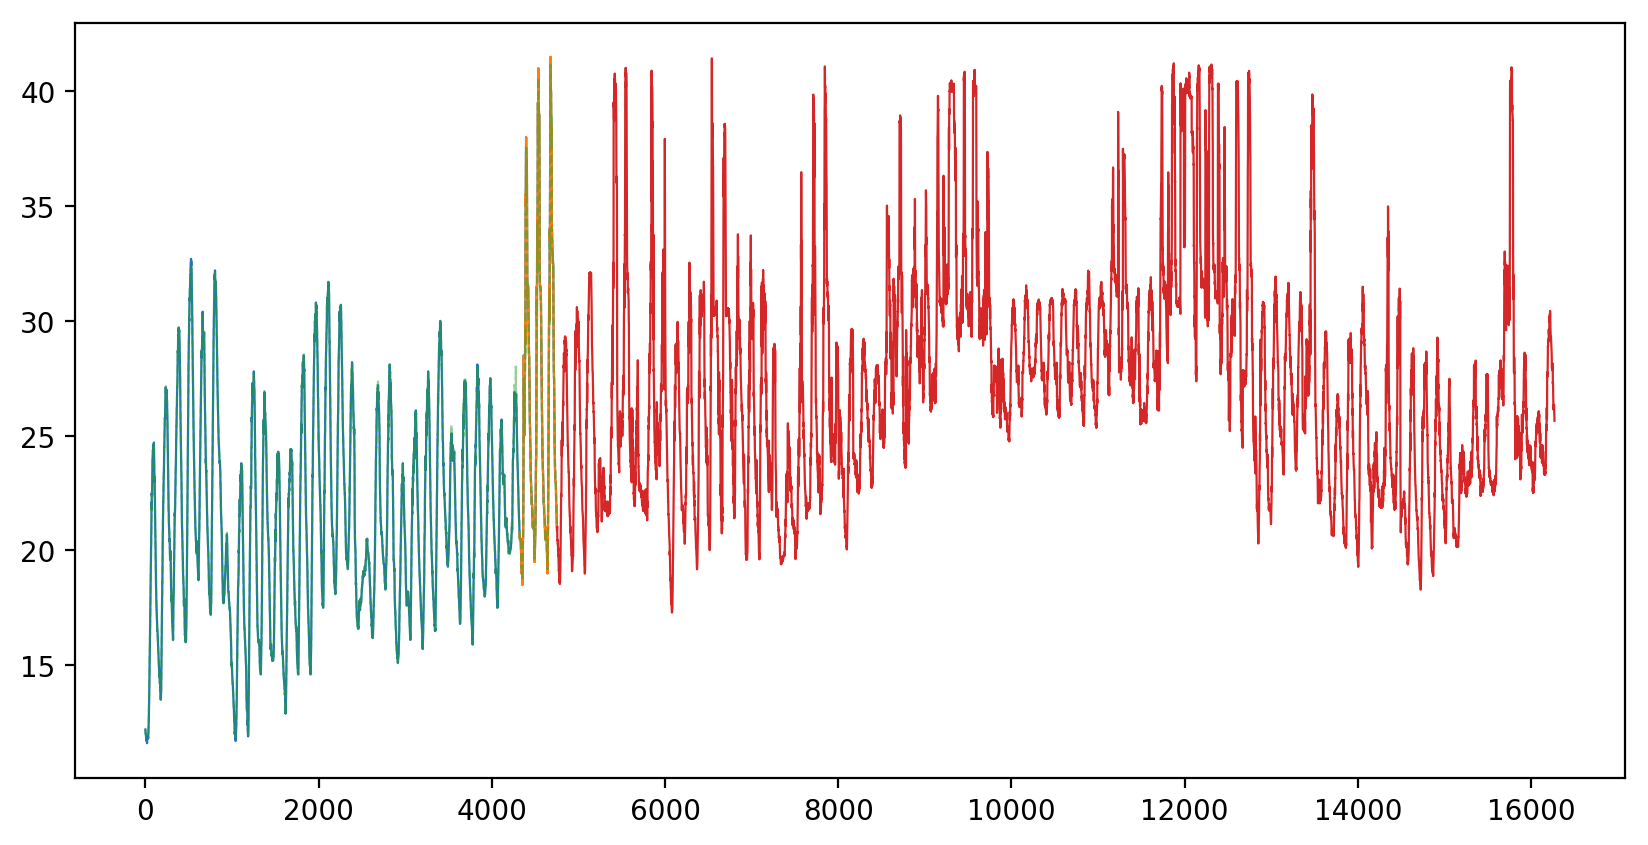

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), dpi=200, sharey=True)
ax.plot(train['Y18'], lw=0.8)
ax.plot(train.loc[4320:, 'Y18'], lw=0.8)
ax.plot(preds, lw=0.8, alpha=0.5, ls='--')
ax.plot(range(4752, 16272), test_preds2, lw=0.8)
# ax.plot(range(4752, 16272), test_preds)
plt.show()

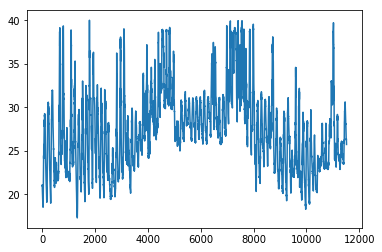

In [400]:
fig, ax = plt.subplots(sharey=True)
ax.plot(test_preds)
plt.show()

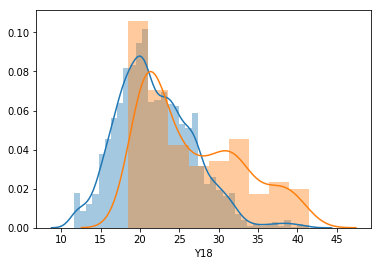

In [282]:
sns.distplot(train['Y18'])
sns.distplot(train.loc[4320:,'Y18'])
plt.show()

In [401]:

# X = train.iloc[2000:].filter(regex='X', axis=1).fillna(0).values
# y = train.iloc[2000:]['Y18'].fillna(0).values


X = train.filter(regex='X', axis=1).values
y = train['Y18'].values
test = test.values
print(X.shape, test.shape)

(4752, 40) (11520, 40)


In [402]:
def aifrenz_mse(preds, train_data):
    labels = train_data.get_label().astype('float')
    diff = abs(labels - preds)
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return 'mse', score, False

In [403]:
# def custom_obj(preds, train_data):
#     labels = train_data
#     diff = abs(labels - preds).astype('float')
#     grad = np.where(diff < 1, 0, 2*diff)
#     hess = np.where(diff < 1, 0, 2.0)
    
# #     hess = np.average(less_then_one ** 2, axis = 0)

#     return grad, hess

# grad, hess = custom_obj(train_preds, train['Y18'])

# fig, ax = plt.subplots(1,1, figsize=(8,4))

# # ax.plot(y_hat, errors)
# ax.plot(train_preds, grad)
# ax.plot(train_preds, hess)
# ax.legend(('gradient', 'hessian'))
# ax.set_xlabel('Predictions')
# ax.set_ylabel('first or second derivates')

# fig.tight_layout()

In [404]:
def aifrenz_mse(preds, train_data):
    labels = train_data.get_label().astype('float')
    diff = abs(labels - preds)
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return 'mse', score, False

In [405]:
# def aifrenz_obj(preds, train_data):
#     labels = train_data.get_label()
#     diff = abs(labels - preds).astype('float')
#     grad = np.where(diff < 1, 0, -1*diff)
# #     grad = np.where(diff < 1, 0, 1*diff)
#     hess = np.where(diff < 1, 0, 1.0)
    
# #     hess = np.average(less_then_one ** 2, axis = 0)

#     return grad, hess

In [410]:
from sklearn.model_selection import KFold
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
#     'device': 'gpu',
    'objective': 'regression',
    'learning_rate': 0.01,
    'max_depth': -1,  
    'reg_alpha': 3,  
    'reg_lambda': 1,  
   'nthread': 8,
    'verbosity': -1,
}


train_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

cv_score = []
best_trees = []

kfold = KFold(n_splits=2)
for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    X_train_data = X[train_index] 
    X_valid_data = X[valid_index]

    y_train_data = y[train_index] 
    y_valid_data = y[valid_index]
    
    dtrain = lgb.Dataset(X_train_data, y_train_data)
    dvalid = lgb.Dataset(X_valid_data, y_valid_data)
    dtest = lgb.Dataset(test)

    bst = lgb.train(params, 
                    dtrain,
#                     fobj=aifrenz_obj,
                    feval=aifrenz_mse,
                     num_boost_round=5000, 
                     valid_sets=[dtrain, dvalid], 
                     verbose_eval=200, 
                     early_stopping_rounds=300)
    
    best_trees.append(bst.best_iteration)
    
    preds = bst.predict(X_valid_data)
    train_preds[valid_index] = preds
    test_preds += bst.predict(test) / kfold.n_splits
    
    score = aifrenz_mse(preds, dvalid)
    print('{}-fold: mse = {}'.format(i+1, score))
    
    cv_score.append(score)

sub.loc[:, 'Y18'] = test_preds
sub.to_csv('submission.csv', index=False)

Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.981903	training's mse: 0.771565	valid_1's l2: 2.52668	valid_1's mse: 2.34488
[400]	training's l2: 0.227015	training's mse: 0.173592	valid_1's l2: 1.42049	valid_1's mse: 1.35017
[600]	training's l2: 0.113383	training's mse: 0.0706968	valid_1's l2: 1.29914	valid_1's mse: 1.23116
[800]	training's l2: 0.0723058	training's mse: 0.0350653	valid_1's l2: 1.27736	valid_1's mse: 1.21056
[1000]	training's l2: 0.0495396	training's mse: 0.0169255	valid_1's l2: 1.26961	valid_1's mse: 1.20263
[1200]	training's l2: 0.037414	training's mse: 0.00922958	valid_1's l2: 1.26204	valid_1's mse: 1.19519
[1400]	training's l2: 0.0302568	training's mse: 0.00633739	valid_1's l2: 1.26001	valid_1's mse: 1.19466
[1600]	training's l2: 0.0249819	training's mse: 0.00400676	valid_1's l2: 1.25795	valid_1's mse: 1.1927
[1800]	training's l2: 0.0216172	training's mse: 0.00299365	valid_1's l2: 1.25674	valid_1's mse: 1.19101
[2000]	training's 

In [122]:
# LB: 12.000 == train mse 6.6

In [407]:
from sklearn.model_selection import KFold
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
#     'device': 'gpu',
    'objective': 'regression',
#     'objective': aifrenz_obj,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'reg_alpha': 3,  
    'reg_lambda': 1,  
   'nthread': 8,
    'verbosity': -1,
}


dtrain = lgb.Dataset(X, y)

bst = lgb.train(params, 
                dtrain,
#                     fobj=aifrenz_obj,
                feval=aifrenz_mse,
                 num_boost_round=3000, 
                 valid_sets=[dtrain], 
                 verbose_eval=200, 
                 early_stopping_rounds=300)


preds = bst.predict(X, num_iteration=bst.best_iteration)
test_preds2 = bst.predict(test, num_iteration=bst.best_iteration)


score = aifrenz_mse(y, dtrain)
print(score)

# sub.loc[:, 'Y18'] = test_preds
# sub.to_csv('submission.csv', index=False)

Training until validation scores don't improve for 300 rounds
[200]	training's l2: 0.757076	training's mse: 0.537808
[400]	training's l2: 0.116161	training's mse: 0.0816497
[600]	training's l2: 0.0549123	training's mse: 0.0320926
[800]	training's l2: 0.0352176	training's mse: 0.0156695
[1000]	training's l2: 0.0253298	training's mse: 0.00785852
[1200]	training's l2: 0.0196837	training's mse: 0.00440547
[1400]	training's l2: 0.0161056	training's mse: 0.00277536
[1600]	training's l2: 0.0138913	training's mse: 0.00175731
[1800]	training's l2: 0.012172	training's mse: 0.00150921
[2000]	training's l2: 0.011217	training's mse: 0.00139244
[2200]	training's l2: 0.010933	training's mse: 0.00115389
[2400]	training's l2: 0.0108638	training's mse: 0.00093957
[2600]	training's l2: 0.0108328	training's mse: 0.000939248
[2800]	training's l2: 0.0107956	training's mse: 0.000937537
[3000]	training's l2: 0.0107956	training's mse: 0.000937537
Did not meet early stopping. Best iteration is:
[2759]	training'